# eq_PR_bias: Zonal structure of time-mean PR in the equatorial Pacific


Computes the zonal root mean square error (RMSE) of equatorial Pacific (150°E-90°W) climatological (time and meridional 5°S-5°N average) precipitation (PR) between model and observations


## Datasets and reanalysis used for comparison

The following reference observational datasets are used to evaluate the model simulations:

- **GPCPv2.3 (1979-2018)**: The primary dataset for comparison. The Global Precipitation Climatology Project (GPCP) combines satellite and surface precipitation measurements to provide comprehensive global precipitation data.
  
Additional observational datasets used for comparison include:
- **20CRv2 (1871-2012)**: The 20th Century Reanalysis provides global atmospheric data, including precipitation, based on surface pressure observations and ensemble assimilation techniques.
- **CMAP (1979-2018)**: The CPC Merged Analysis of Precipitation (CMAP) is a blend of gauge and satellite observations, offering global precipitation estimates.
- **ERA-Interim (1979-2018)**: Reanalysis data produced by the European Centre for Medium-Range Weather Forecasts (ECMWF), providing atmospheric variables, including precipitation, based on a large-scale model and historical observations.
- **NCEP2 (1979-2018)**: The second generation of the National Centers for Environmental Prediction (NCEP) reanalysis, offering precipitation and other atmospheric variables.

## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40143,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37317,Total threads: 3
Dashboard: /proxy/37931/status,Memory: 23.75 GiB
Nanny: tcp://127.0.0.1:35213,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    tier=2),
# "NOAA-CIRES-20CR-V2": 
#     Dataset(
#     short_name='pr',
#     dataset='NOAA-CIRES-20CR-V2',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="187101/201212",
#     tier=2),
# "CMAP": 
#     Dataset(
#     short_name='pr',
#     dataset='CMAP',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="197901/202408",
#     tier=2),
## ERA-Interim not available in Tier2. Conctact NRI
# "ERA-Interim": 
#     Dataset(
#     short_name='pr',
#     dataset='ERA-Interim',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [4]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [6]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

AttributeError: 'Cube' object has no attribute 'load'

In [ ]:
model_datasets

## Pre-processors

In [7]:
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import mask_landsea

In [8]:
def preproc1(cube):
    equatorial_pacific_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    # print(cube)
    cube = climate_statistics(cube, operator="mean", period="full")
    print(cube)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    print(cube)
    cube = extract_region(cube, **equatorial_pacific_region)
    cube = axis_statistics(cube, operator="mean", axis="y")
    return cube

def preproc2(cube):
    # equatorial_pacific_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    equatorial_pacific_region = {"start_longitude": 0., "end_longitude": 360.,"start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **equatorial_pacific_region)
    return cube

def preproc3(cube):
    # equatorial_pacific_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    #equatorial_pacific_region = {"start_longitude": 0., "end_longitude": 360.,"start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    #cube = extract_region(cube, **equatorial_pacific_region)
    return cube

In [9]:
# model_datasets_prep1 = {name: preproc1(dataset) for name, dataset in model_datasets.items()}
# obs_datasets_prep1 = {name: preproc1(dataset) for name, dataset in obs_datasets.items()}

# model_datasets_prep2 = {name: preproc2(dataset) for name, dataset in model_datasets.items()}
# obs_datasets_prep2 = {name: preproc2(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}

In [10]:
model_datasets_prep3['ACCESS-ESM1-5'].shape

(180, 360)

In [11]:
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [ ]:
def get_transparent(data, colourmap, blur=2.5):
    # lat = data['lat'].values
    # lon = data['lon'].values
    # newlon = np.linspace(lon[0], lon[-1], 2048)
    # newlat = np.linspace(lat[0], lat[-1], 1024)

    # interpolated = data.interp(lon=newlon, lat=newlat, method="linear")
    if blur > 0:
        # interpolated_array=interpolated.to_dataarray()
        smoothed = gaussian_filter(interpolated, sigma=blur)
        #smoothed = median_filter(interpolated, size=blur)
    else:
        #No blur
        smoothed = interpolated

    #Convert to image, use raw interpolated data as opacity map for transparency
    rgba = accessvis.array_to_rgba(smoothed, flip=True, colourmap=colourmap, opacitymap=True)
    return rgba

In [ ]:
obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

In [ ]:
padded_obs_data = np.pad(obs_data.data, pad_width=((75, 75), (0, 0)), mode='constant', constant_values=0)
padded_model_data = np.pad(model_data.data, pad_width=((75, 75), (0, 0)), mode='constant', constant_values=0)

In [ ]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -150.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
# lv.display(resolution=(600,600))
cmap = cmocean.cm.balance
colours_obs = accessvis.array_to_rgba(padded_obs_data, flip=True, colourmap=cmap, opacitymap=True)
accessvis.update_earth_values(lv, dataMode=0, data=colours_obs)
cb = lv.colourbar()
# lv.display(resolution=(600,600))
lv.window(resolution=(600,600))

In [ ]:
cam = lv.camera()
print(cam)
print(type(cam))
lv.camera(cam)
lv.display(resolution=(600,600))

In [ ]:
lv.camera(cam)
lv.display(resolution=(600,600))

In [50]:
colours_model = accessvis.array_to_rgba(padded_model_data, flip=True, colourmap=cmap, opacitymap=True)
accessvis.update_earth_values(lv, dataMode=0, data=colours_model)
cb = lv.colourbar()
lv.window(resolution=(600,600))

In [65]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -150.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
# lv.display(resolution=(600,600))
cmap = cmocean.cm.balance
model_prep3=model_datasets_prep3['ACCESS-ESM1-5'].data
smoothed = gaussian_filter(model_prep3, sigma=1.0)
colours_models = accessvis.array_to_rgba(smoothed, flip=True, colourmap=cmap,opacitymap=True)
accessvis.update_earth_values(lv, dataMode=0, data=colours_models)
cb = lv.colourbar()
# lv.display(resolution=(600,600))
lv.window(resolution=(600,600))

# Diagnostics Level 1


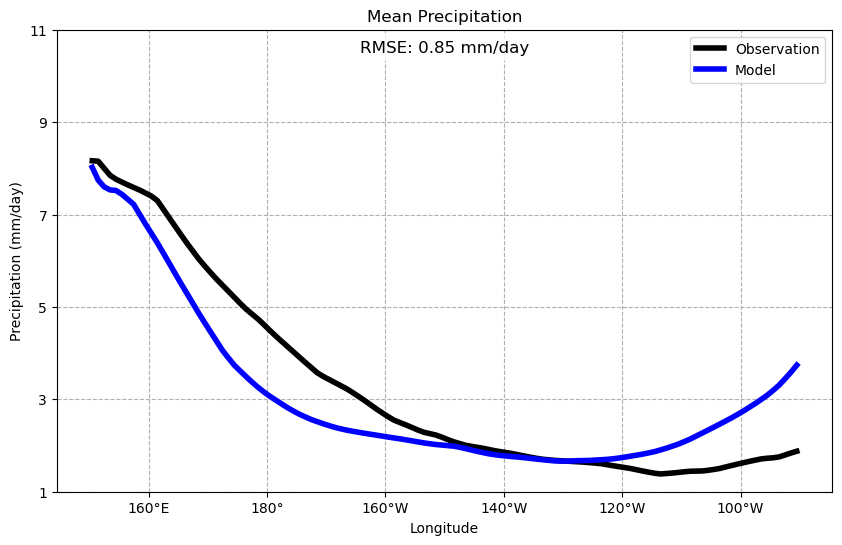

In [11]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["GPCP-SG"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Precipitation (mm/day)')
plt.title('Mean Precipitation')
plt.grid(linestyle='--')
plt.yticks(np.arange(1,12, step=2))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} mm/day', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [21]:
obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# print(obs_data.data.shape)
# print(model_data)

padded_obs_data = np.pad(obs_data.data, pad_width=((75, 75), (0, 0)), mode='constant', constant_values=0)
padded_model_data = np.pad(model_data.data, pad_width=((75, 75), (0, 0)), mode='constant', constant_values=0)

print(padded_obs_data.shape)  # (180, 360)
print(padded_model_data.shape)

(180, 360)
(180, 360)


In [23]:
import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib64/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib64/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib64/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib64/dri, suffix _dri)



In [22]:
lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -190.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
# date = accessvis.TextWidget(lv=lv, text_colour = 'black', scale=0.05, offset=(1,0))

NameError: name 'accessvis' is not defined

Figure 1: Zonal bias in the time-mean precipitation (PR) structure across the equatorial Pacific (averaged between 5°S–5°N), illustrating the increased precipitation in the eastern Pacific and decreased precipitation in the western Pacific. The black curve represents the reference data, while the blue curve represents the model data. The metric shown is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


(30, 360)
lwe_precipitation_rate / (mm/day)   (latitude: 30; longitude: 360)
    Dimension coordinates:
        latitude                             x              -
        longitude                            -              x
    Scalar coordinates:
        time                        1996-12-31 12:00:00, bound=(1979-01-01 00:00:00, 2015-01-01 00:00:00)
    Cell methods:
        0                           area: time: mean
        1                           time: mean
    Attributes:
        Conventions                 'CF-1.7 CMIP-6.2'
        activity_id                 'CMIP'
        branch_method               'standard'
        branch_time_in_child        0.0
        branch_time_in_parent       -616894
        cmor_version                '3.4.0'
        data_specs_version          '01.00.30'
        experiment                  'all-forcing simulation of the recent past'
        experiment_id               'historical'
        external_variables          'areacella'
        forc

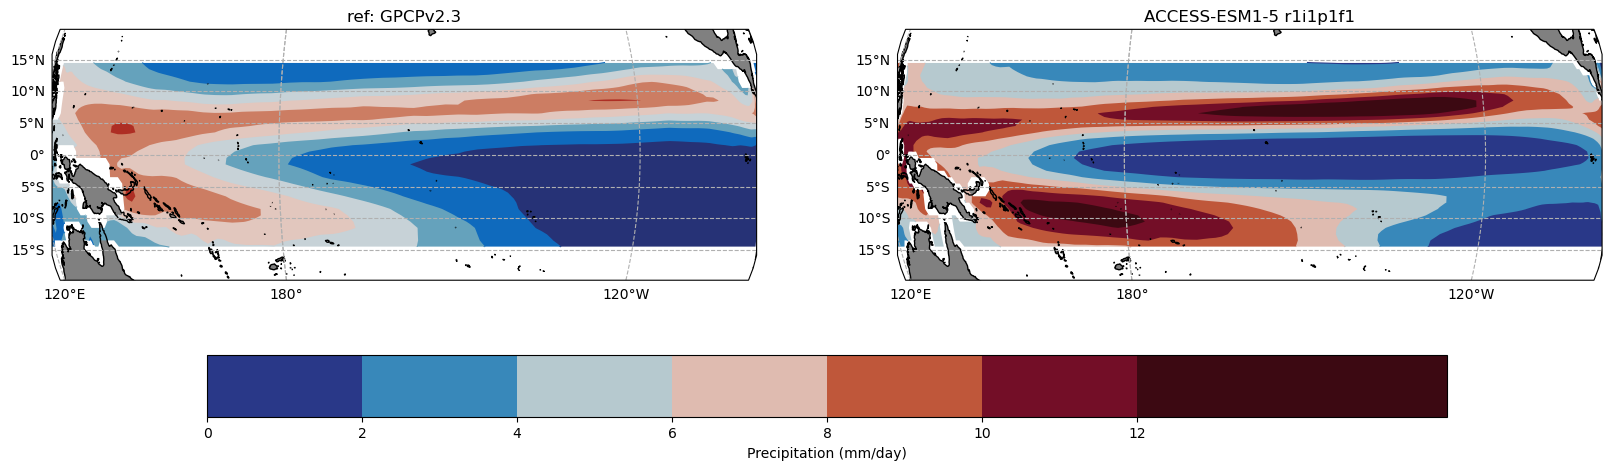

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

print(obs_data.shape)
print(model_data)

# Create a colormap from cmocean balance
cmap = cmocean.cm.balance
colors = cmap(np.linspace(0, 1, 14))

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of 0 to 12 mm
norm = mcolors.Normalize(vmin=0, vmax=12)

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ref: GPCPv2.3")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('Precipitation (mm/day)')
cbar.set_ticks(np.arange(0, 13, 2))  # Set ticks at intervals of 2 mm

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Time-mean precipitation (PR) bias in the equatorial Pacific, primarily highlighting the double intertropical convergence zone (ITCZ) bias. The reference data is shown on the left map, and the model data on the right.